In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor 
from sklearn.svm import SVR 
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import RandomizedSearchCV 
from catboost import CatBoostRegressor 
from xgboost import XGBRegressor 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from math import sqrt 

In [2]:
df = pd.read_csv('data/market_data.csv', parse_dates=['Arrival_Date'], dayfirst=True) 
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   State         18524 non-null  object        
 1   District      18524 non-null  object        
 2   Market        18524 non-null  object        
 3   Commodity     18524 non-null  object        
 4   Variety       18524 non-null  object        
 5   Grade         18524 non-null  object        
 6   Arrival_Date  18524 non-null  datetime64[ns]
 7   Min Price     18524 non-null  float64       
 8   Max Price     18524 non-null  float64       
 9   Modal Price   18524 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 1.4+ MB


(None,
             State   District           Market       Commodity         Variety  \
 0  Andhra Pradesh  Anantapur         Hindupur  Tamarind Fruit  Non A/c Flower   
 1  Andhra Pradesh    Chittor         Kalikiri          Tomato          Hybrid   
 2  Andhra Pradesh    Chittor      Madanapalli          Tomato           Local   
 3  Andhra Pradesh    Chittor  Mulakalacheruvu          Tomato           Local   
 4  Andhra Pradesh    Chittor       Vayalapadu          Tomato          Hybrid   
 
   Grade Arrival_Date  Min Price  Max Price  Modal Price  
 0   FAQ   2025-04-24     4100.0    12800.0       8000.0  
 1   FAQ   2025-04-24      800.0     1000.0        930.0  
 2   FAQ   2025-04-24     1000.0     1200.0       1100.0  
 3   FAQ   2025-04-24      900.0     1100.0       1000.0  
 4   FAQ   2025-04-24      920.0     1120.0       1040.0  )

In [3]:
dups = df.duplicated().sum() 
print(dups)

0


In [4]:
print(df[['Min Price','Max Price', 'Modal Price']].describe())

           Min Price      Max Price    Modal Price
count   18524.000000   18524.000000   18524.000000
mean     3705.916444    4372.394443    4169.146708
std      4211.137959    5150.700922    4763.529213
min         0.000000       0.000000       3.000000
25%      1600.000000    2000.000000    2000.000000
50%      2600.000000    3000.000000    3000.000000
75%      4500.000000    5400.000000    5010.000000
max    140000.000000  225000.000000  182500.000000


In [5]:
print(df.nunique()) 
print(df['Commodity'].value_counts().head(10))

State             27
District         440
Market          1482
Commodity        213
Variety          453
Grade              6
Arrival_Date       1
Min Price       1514
Max Price       1864
Modal Price     1792
dtype: int64
Commodity
Wheat                    768
Onion                    680
Tomato                   659
Potato                   640
Brinjal                  574
Green Chilli             539
Banana                   475
Bhindi(Ladies Finger)    461
Bottle gourd             443
Bitter gourd             411
Name: count, dtype: int64


/Users/joyaljijo/Developer/pragati/notebook/.venv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


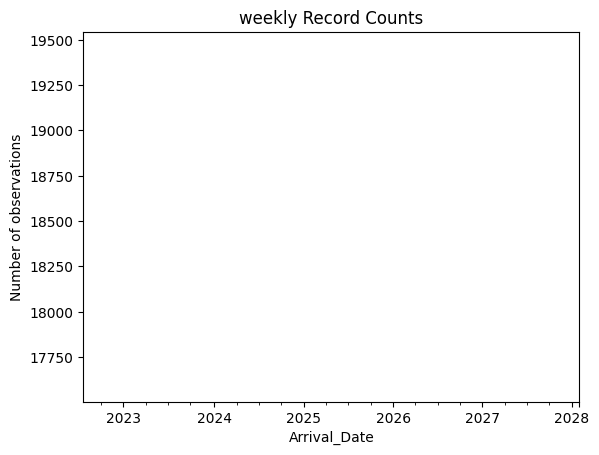

In [7]:
weekly = df.set_index('Arrival_Date')['Modal Price'].resample('W').count() 
weekly.plot(title='weekly Record Counts') 
plt.ylabel('Number of observations') 
plt.show() 

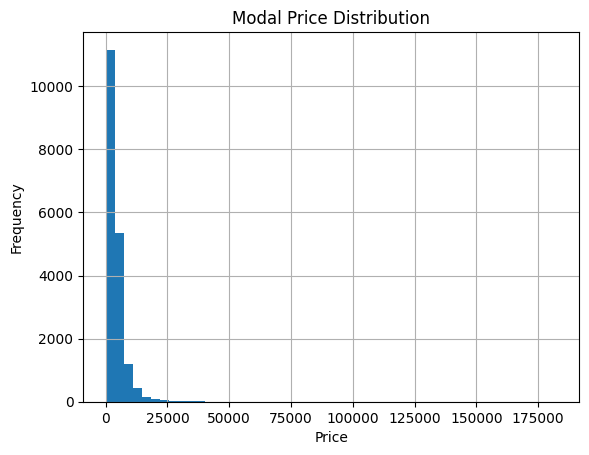

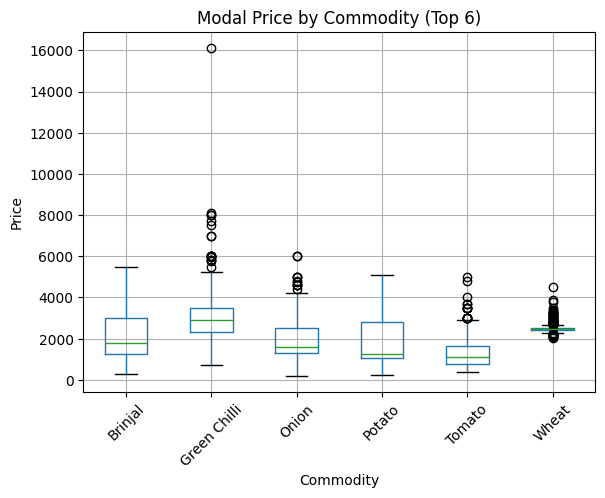

In [8]:
# overall histogram
df['Modal Price'].hist(bins=50)
plt.title('Modal Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# boxplot by Commodity (pick top N)
top_com = df['Commodity'].value_counts().nlargest(6).index
df_box = df[df['Commodity'].isin(top_com)]
df_box.boxplot(column='Modal Price', by='Commodity', rot=45)
plt.title('Modal Price by Commodity (Top 6)')
plt.suptitle('')
plt.ylabel('Price')
plt.show()


In [9]:
bad = df[~((df['Min Price'] <= df['Modal Price']) & (df['Modal Price'] <= df['Max Price']))]
print(f"Rows with inconsistent prices: {len(bad)}")
# Investigate or drop these rows

Rows with inconsistent prices: 20


In [10]:
# count per Commodity
com_counts = df['Commodity'].value_counts()

# list those with <10 rows
rare_coms = com_counts[com_counts < 100].index.tolist()
print(f"Commodities with fewer than 100 records ({len(rare_coms)} groups):\n", rare_coms)


Commodities with fewer than 100 records (154 groups):
 ['Sweet Potato', 'Thondekai', 'Gur(Jaggery)', 'Yam (Ratalu)', 'Orange', 'Bajra(Pearl Millet/Cumbu)', 'Knool Khol', 'Amla(Nelli Kai)', 'Spinach', 'Lime', 'Tender Coconut', 'Castor Seed', 'Green Peas', 'Pointed gourd (Parval)', 'Pineapple', 'Jowar(Sorghum)', 'Arhar Dal(Tur Dal)', 'French Beans (Frasbean)', 'Mashrooms', 'Cotton', 'Black Gram (Urd Beans)(Whole)', 'Barley (Jau)', 'Jack Fruit', 'Tamarind Fruit', 'Guar', 'Cummin Seed(Jeera)', 'Peas Wet', 'Green Gram Dal (Moong Dal)', 'Fish', 'Kabuli Chana(Chickpeas-White)', 'Sweet Pumpkin', 'Black Gram Dal (Urd Dal)', 'Sponge gourd', 'Corriander seed', 'Little gourd (Kundru)', 'Methi Seeds', 'Ginger(Dry)', 'Marigold(Calcutta)', 'Bengal Gram Dal (Chana Dal)', 'Mustard Oil', 'Green Gram (Moong)(Whole)', 'Masur Dal', 'Rose(Local)', 'Tinda', 'Arecanut(Betelnut/Supari)', 'Indian Beans (Seam)', 'Sesamum(Sesame,Gingelly,Til)', 'Methi(Leaves)', 'Jasmine', 'White Peas', 'Soanf', 'Betal Leaves', 'A

In [11]:
df = df[~df['Commodity'].isin(rare_coms)]

In [12]:
# count per Commodity
com_counts = df['Commodity'].value_counts()

# list those with <10 rows
rare_coms = com_counts[com_counts < 10].index.tolist()
print(f"Commodities with fewer than 10 records ({len(rare_coms)} groups):\n", rare_coms)

Commodities with fewer than 10 records (0 groups):
 []


In [13]:
# Number of unique commodities
num_unique_commodities = df['Commodity'].nunique()
print(f"Number of unique commodities: {num_unique_commodities}")

# Frequency count of each commodity
commodity_counts = df['Commodity'].value_counts()
print("\nTop commodities by record count:\n", commodity_counts.head())

# If you want to display all:
print(commodity_counts.to_string())

Number of unique commodities: 59

Top commodities by record count:
 Commodity
Wheat      768
Onion      680
Tomato     659
Potato     640
Brinjal    574
Name: count, dtype: int64
Commodity
Wheat                          768
Onion                          680
Tomato                         659
Potato                         640
Brinjal                        574
Green Chilli                   539
Banana                         475
Bhindi(Ladies Finger)          461
Bottle gourd                   443
Bitter gourd                   411
Pumpkin                        392
Cabbage                        391
Cauliflower                    380
Cucumbar(Kheera)               369
Ginger(Green)                  335
Bengal Gram(Gram)(Whole)       302
Lemon                          299
Carrot                         278
Banana - Green                 262
Raddish                        259
Garlic                         253
Coriander(Leaves)              247
Papaya                         237
Maize 

In [14]:
df = pd.read_csv("data/market_data.csv", parse_dates=["Arrival_Date"], dayfirst=True)
counts = df["Commodity"].value_counts() 
keep = counts[counts >= 100].index 
df = df[df["Commodity"].isin(keep)].reset_index(drop=True) 

In [15]:
# 2. Feature engineering: lags, rolling, calendar
df = df.sort_values(["Commodity", "Market", "Arrival_Date"])
group_cols = ["Commodity", "Market"]

# Prepare a list to track the lag column names
lag_cols = []

# Create proper lag‑1 columns
for col in ["Modal Price", "Min Price", "Max Price"]:
    clean = col.replace(" ", "").lower()          # remove the space
    lag_name = f"lag1_{clean}"
    df[lag_name] = df.groupby(group_cols)[col].shift(1)
    lag_cols.append(lag_name)

# 7‑day rolling mean of modal price up to the previous day
df["roll7_modal"] = (
    df.groupby(group_cols)["Modal Price"]
      .apply(lambda x: x.shift(1).rolling(window=7).mean())
      .reset_index(level=group_cols, drop=True)
)

# Calendar features
df["year"]        = df["Arrival_Date"].dt.year
df["month"]       = df["Arrival_Date"].dt.month
df["day_of_week"] = df["Arrival_Date"].dt.dayofweek

# Now drop rows missing any of our engineered features
df_model = df.dropna(subset=lag_cols + ["roll7_modal"]).copy()

# Define target and features
target = "Modal Price"
feature_cols = (
    lag_cols +                  # ['lag1_modalprice','lag1_minprice','lag1_maxprice']
    ["roll7_modal","year","month","day_of_week","Commodity","Market"]
)

X = df_model[feature_cols]
y = df_model[target]

# Then you can split, build pipelines, etc.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [16]:
numeric_feats = lag_cols + ["roll7_modal", "year", "month", "day_of_week"]
cat_feats     = ["Commodity", "Market"]
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_feats)
])

In [26]:
import itertools 

def get_param_space_size(param_grid):
    if not param_grid: 
        return 1 
    sizes = [] 
    for v in param_grid.values():
        if isinstance(v, list):
            sizes.append(len(v)) 
        else: 
            sizes.append(1) 
    return np.prod(sizes)

models = {
    "KNN": (
        KNeighborsRegressor(),
        {"reg__n_neighbors": [1, 3, 5]}
    ),
    "DecisionTree": (
        DecisionTreeRegressor(random_state=42),
        {"reg__max_depth": [None, 5, 10, 20],
         "reg__min_samples_leaf": [1, 5, 10]}
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {"reg__n_estimators": [100, 200],
         "reg__max_depth": [None, 10, 20],
         "reg__min_samples_leaf": [1, 5]}
    ),
    "AdaBoost": (
        AdaBoostRegressor(random_state=42),
        {"reg__n_estimators": [50, 100],
         "reg__learning_rate": [0.01, 0.1, 1]}
    ),
    "SVR": (
        SVR(),
        {"reg__C": [0.1, 1, 10],
         "reg__gamma": ["scale", "auto"],
         "reg__kernel": ["rbf"]}
    ),
    "Linear": (
        LinearRegression(),
        {}
    ),
    "Ridge": (
        Ridge(random_state=42, max_iter=50000),
        {"reg__alpha": [0.1, 1, 10, 50]}
    ),
    "Lasso": (
        Lasso(random_state=42, max_iter=50000),
        {"reg__alpha": [0.01, 0.1, 1, 10]}
    ),
    "XGBoost": (
        XGBRegressor(random_state=42, n_jobs=-1),
        {"reg__n_estimators": [100, 200],
         "reg__learning_rate": [0.01, 0.05, 0.1],
         "reg__max_depth": [3, 6, 10]}
    ),
    "CatBoost": (
        CatBoostRegressor(random_seed=42, silent=True),
        {"reg__iterations": [200, 500],
         "reg__depth": [4, 6],
         "reg__learning_rate": [0.05, 0.1]}
    ),
}

results = []
best_overall = {"rmse": np.inf, "model": None, "name": None}

for name, (est, param_grid) in models.items():
    pipe = Pipeline([("pre", preprocessor), ("reg", est)])
    param_space_size = get_param_space_size(param_grid)
    n_iter = min(10, param_space_size)
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=3,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)

    best_pipe = search.best_estimator_
    preds = best_pipe.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, preds))
    mae  = mean_absolute_error(y_test, preds)
    r2   = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "Best_Params": search.best_params_,
        "Test_RMSE": rmse,
        "Test_MAE": mae,
        "Test_R2": r2
    })

    if rmse < best_overall["rmse"]:
        best_overall = {"rmse": rmse, "model": best_pipe, "name": name}


results_df = pd.DataFrame(results).sort_values("Test_RMSE").reset_index(drop=True)
print(results_df)

results_df = pd.DataFrame(results).sort_values("Test_RMSE").reset_index(drop=True)
print(results_df)

/Users/joyaljijo/Developer/pragati/notebook/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.239e+02, tolerance: 2.252e+02
  model = cd_fast.enet_coordinate_descent(
/Users/joyaljijo/Developer/pragati/notebook/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e+06, tolerance: 6.068e+02
  model = cd_fast.enet_coordinate_descent(
/Users/joyaljijo/Developer/pragati/notebook/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

          Model                                        Best_Params  \
0  DecisionTree  {'reg__min_samples_leaf': 5, 'reg__max_depth':...   
1  RandomForest  {'reg__n_estimators': 100, 'reg__min_samples_l...   
2           SVR  {'reg__kernel': 'rbf', 'reg__gamma': 'scale', ...   
3           KNN                            {'reg__n_neighbors': 5}   
4       XGBoost  {'reg__n_estimators': 100, 'reg__max_depth': 3...   
5      CatBoost  {'reg__learning_rate': 0.05, 'reg__iterations'...   
6      AdaBoost  {'reg__n_estimators': 50, 'reg__learning_rate'...   
7         Ridge                                  {'reg__alpha': 1}   
8        Linear                                                 {}   
9         Lasso                                 {'reg__alpha': 10}   

     Test_RMSE     Test_MAE   Test_R2  
0  3492.156390  3000.000000 -0.355017  
1  3497.414054  3000.000000 -0.359101  
2  3530.326291  3001.961471 -0.384800  
3  3616.683564  3000.000000 -0.453378  
4  3859.976623  3000.000000 -

In [25]:
best_model = best_overall['model'] 
print(f"Best model: {best_overall['name']} with RMSE={best_overall['rmse']:.2f}")


Best model: DecisionTree with RMSE=3492.16


In [ ]:
joblib.dump(best_model, 'market_price_model.pkl') 

In [ ]:
import time
from datetime import datetime, timedelta

import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select

In [ ]:
from bs4 import BeautifulSoup
from selenium import webdriver
import time

driver = webdriver.Chrome()         # uses Selenium Manager to auto‑fetch ChromeDriver 
driver.get("https://enam.gov.in/web/dashboard/trade-data")
time.sleep(5)                       # give the JS a moment to render

soup = BeautifulSoup(driver.page_source, "html.parser")
for sel in soup.find_all("select"):
    print({
        "id": sel.get("id"),
        "name": sel.get("name"),
        "class": sel.get("class"),
        "first_option": sel.find("option").text.strip()
    })

driver.quit()


In [ ]:
import time
from datetime import datetime, timedelta

import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC

def fetch_enam_trade_data(commodity, state, target_date, days=7, timeout=15):
    """
    Scrape e-NAM Trade Details for the last `days` up to `target_date`,
    selecting only State and Commodity. Handles common variations in button/table IDs.
    Returns a DataFrame with ['Arrival_Date','Min Price','Modal Price','Max Price'].
    """
    # 1) compute date strings
    end_dt   = pd.to_datetime(target_date)
    start_dt = end_dt - timedelta(days=days)
    from_str = start_dt.strftime("%d-%b-%Y")
    to_str   = end_dt.strftime("%d-%b-%Y")

    # 2) launch Chrome via Selenium Manager
    driver = webdriver.Chrome()
    driver.maximize_window()
    driver.get("https://enam.gov.in/web/dashboard/trade-data")
    wait = WebDriverWait(driver, timeout)

    # 3) select State (new ID)
    state_sel = wait.until(
        EC.presence_of_element_located((By.ID, "min_max_state"))
    )
    Select(state_sel).select_by_visible_text(state)

    # 4) select Commodity (new ID)
    comm_sel = wait.until(
        EC.presence_of_element_located((By.ID, "min_max_commodity"))
    )
    Select(comm_sel).select_by_visible_text(commodity)

    # 5) fill dates
    from_in = wait.until(
        EC.presence_of_element_located((By.ID, "txtFromDate"))
    )
    to_in = driver.find_element(By.ID, "txtToDate")
    from_in.clear(); from_in.send_keys(from_str)
    to_in.clear();   to_in.send_keys(to_str)

    # 6) click the “Get Data” / “Search” button (try common IDs)
    for btn_id in ("btnGetData", "btnSearch", "min_max_submit"):
        try:
            btn = driver.find_element(By.ID, btn_id)
            btn.click()
            break
        except:
            continue
    else:
        raise RuntimeError("Could not find any known submit button")

    # 7) wait for the results table to appear (try common IDs)
    table_id_candidates = ["tblTradeData", "trade-data-table", "tblTradeDetails"]
    table_elem = None
    for tid in table_id_candidates:
        try:
            table_elem = wait.until(EC.presence_of_element_located((By.ID, tid)))
            break
        except:
            continue
    if table_elem is None:
        raise RuntimeError("Trade-data table did not appear")

    # 8) parse HTML
    soup = BeautifulSoup(driver.page_source, "html.parser")
    driver.quit()

    # 9) extract rows
    table = soup.find("table", id=table_elem.get_attribute("id"))
    headers = [th.get_text(strip=True) for th in table.find_all("th")]
    rows = []
    for tr in table.find_all("tr")[1:]:
        cols = [td.get_text(strip=True) for td in tr.find_all("td")]
        if cols:
            rows.append(cols)

    # 10) build DataFrame
    df = pd.DataFrame(rows, columns=headers)
    df.rename(columns={"Date":"Arrival_Date"}, inplace=True)
    df["Arrival_Date"] = pd.to_datetime(df["Arrival_Date"], dayfirst=True)
    for col in ["Min Price","Modal Price","Max Price"]:
        df[col] = df[col].str.replace(",", "").astype(float)

    return df



hist = fetch_enam_trade_data(
    commodity="WHEAT",
    state="HARYANA",
    target_date="2025-04-22",
    days=6
)
print(hist)
    # Now: compute your lag1_*/roll7_modal features and feed into your model.
